In [1]:
import numpy as np
import matplotlib.pyplot as py

An approximation for the spiral arms eminating from the sun at the scale of LISA is a transition line. Using a line instead of a spiral allows for a profile equation to be defined perpendicular to the transition line. Instead of using a hard cutoff at the transition line, a smooth sigmoid falloff is defined. The equation for a sigmoid is:

$$
Sigmoid(x) = \frac{1}{1+e^{-x}}
$$

or more generally:

$$
Sigmoid(x) = \frac{1}{1+e^{-a(x-b)}}
$$
Where $a$ defines the falloff rate (higher $a$ results in a quicker falloff), and $b$ is an offset, because at x=0, the sigmoid may not necessarily evaluate to half intensity. This will be clearer later. Below, relevant constants are defined.

In [19]:
v = 600 # wind speed km/s
Wangle = 0 #angle of wind flow (from x axis)
Langle = np.pi/2 #angle of the transition line (0)
sigfalloff = 500

L = 1/60 # lisa arm length in AU

AUtokm = 149600000 #km per AU
rotation = np.pi/2 #LISA pre-rotation around z axis

bgdensity = 3
spiraldensity = 10 #electron density of the background and the spiral per cm^-3

armres = 250 #resolution of each lisa arm



Below, a rotation matrix is defined, relevant when rotating LISA.

In [20]:
def eulerRot3D(RotObj, Xangle, Yangle, Zangle):
    
    sa = np.sin(Zangle) #sin and cos of x,y,z angles
    ca = np.cos(Zangle)
    sb = np.sin(Yangle)
    cb = np.cos(Yangle)
    sc = np.sin(Xangle)
    cc = np.cos(Xangle)
    
    rotmat = np.array([[ca*cb, ca*sb*sc - sa*cc, ca*sb*cc + sa*sc], [sa*cb, sa*sb*sc + ca*cc, sa*sb*cc - ca*sc], [-sb, cb*sc, cb*cc]])
    
    return np.matmul(rotmat, RotObj)
    
    

The equation for a sigmoid. $-b$ is used instead of $b$ because that sets the 'zero point' to b. The other reason is it worked visually when designing this system in blender. 

In [21]:
def sigmoid(x, a, b):
    return 1/(1 + np.exp(a*(x-b))) #returns sigmoid - note the -b, not +b

Below, the logic for evaluating the average density requires finding the density of each sampled point on a LISA arm, and summing them up. Finding the density of each point is simply a problem of finding the distance of the point from the transition line. For example, if the point is 10 units away from the closest point of the transition line, the sigmoid simply needs to be evaluated at x=10 (or -10, depending on the orientation). This works because the sigmoid extends perpendicularly from the transition line, which is also the condition for closest distance from the line.

to find the distance to the line, the line's trajectory needs to be evaluated as a function of time. The line is defined by a certain rotation angle (called the line angle), passes through the origin at t=0, and sweeps a 2D plane based on the wind angle (except for the case where the wind angle and line angle are the same). To find the distance to this line, the base case at t=0 can be evaluated (technically when the line passes the origin, but that happens at t=0), then an offset can be added based on how fast the line travels perpendicular to itself based on the wind speed and angle.

To find the base case requires simple trigonometry. A 2D grid can be drawn with the line passing through the origin. A line connecting the origin and LISA's point can be drawn. Since the angle from the line has to be 90 degrees, this creates a right triangle whose height is the distance from the line. The hypotenuse is known (distance of point from the origin, euclidian distance), and the angle of the point can be calculated using arctan2. The relevant angle can be calculated by subtracting the point's angle from the line angle (it gives a negative angle when the line is above the point, but this is a desired property). Then the height can be calculated using

$$
\sin(\theta_{point} - \theta_{line}) = \frac{x}{r}
$$

Since $r$ (distance of the point from the origin) and $\theta_{point} - \theta_{line}$ (difference between point's and line's angles) are known, the base case is done. 

Next, the offset. The wind velocity and angle determine how fast the line sweeps the plane. Only the component of wind that is perpendicular to the line influences the line's position - this can be calculated using a dot product:

$$
v_{perpendicular} = v \cdot \hat n = v*1*cos(\theta_{wind} - (\theta_{line} + \frac{\pi}{2})) = v\sin(\theta_{wind} - \theta_{line})
$$

where $v$ is the wind speed, $\hat n$ is the normal vector to the line (whose angle is $\theta_{line} + \frac{\pi}{2}$), and $\theta_{wind} - \theta_{line}$ is the difference between the wind and line's angles. Multiplying this by time gives the distance that the transition line has travelled towards or away from the point. 

When evaluating as a sigmoid, $x$ needs to be a function of time, while $b$ is a constant. Hence, the base case can be represented as $b$, while the offset case ($v\sin(\theta_{wind} - \theta_{line})*t$) can be represented as $x$. $a$ is an arbitrarily set variable that represents how fast the transition falls off. In reality, this will be a function of the properties of the solar wind (eg. a flare's intenisty, wind speed, etc.). 

Once each point's sigmoid value is known, it can be remapped from 0 to 1 to lower intensity to higher intensity, which in this case is 3 to 5 electrons per $cm^{-3}$. 

In [22]:
def avgDensLine(armlen, armrot, armres, armidx, time, windvel, windang, lineang, sigmoidfalloff, highdens, bgdens):
    
    start = np.array([armlen/np.sqrt(3) * np.cos((armidx)*2*np.pi/3), armlen/np.sqrt(3) * np.sin((armidx)*2*np.pi/3), 0]) #defining start and end coordinates of the arm
    end = np.array([armlen/np.sqrt(3) * np.cos((armidx+1)*2*np.pi/3), armlen/np.sqrt(3) * np.sin((armidx+1)*2*np.pi/3), 0])
    
    pos = np.array([start, end]).T #transposed for dimensions
    pos = eulerRot3D(pos, 0, 0, armrot) #rotating points around origin by the specified 'armrot' angle
    
    X = np.linspace(pos[0,0], pos[0,1], armres) #subdividing laser arm to the specified resolution
    Y = np.linspace(pos[1,0], pos[1,1], armres)
    Z = np.linspace(pos[2,0], pos[2,1], armres)
    
    pointang = np.arctan2(Y,X) #angle of point with correct quadrant
    pointmag = np.sqrt(X**2 + Y**2)
    
    distfromline = np.sin(pointang - lineang) * pointmag #calculating the closest distance of the point from the line
        
    perpvel = windvel * np.sin(windang - lineang) #velocity perpendicular to line is the dot product between the line's normal and wind vectors
    
    fraction = sigmoid(perpvel*time, sigmoidfalloff, distfromline) #intensity from 0 to 1 of the wind density at the relevant point
    
    densvect = fraction*highdens + (1-fraction)*bgdens
    avgdens = np.sum(densvect)/armres
    
    return avgdens

Testing in blender showed that for the parameters specified above, the approximate time the line takes to cross LISA is 10000 seconds, or about 160 minutes. Units are in AU and minutes for distance and time respectively. 

In [23]:

time = np.linspace(-5000,5000, 200) #set time to evaluate densities
timemins = time/60 #time in minutes
vminsAU = v*60/AUtokm #velocity in au/min
vAU = v/AUtokm #velocity in au/sec

averages = {} #empty dictionary, to hold arm-averagedensity pairs
averagesec = {} #same, but units of au/seconds instead of au/minutes

for i in range(3): #for each arm
    averages['avgdens'+str(i)] = [] #setting an empty list to fill with averages
    averagesec['avgdens'+str(i)] = [] #au/sec
    
    for j in timemins: #for each angle
        averages['avgdens'+str(i)].append(avgDensLine(L, rotation, armres, i, j, vminsAU, Wangle, Langle, sigfalloff, spiraldensity, bgdensity)) #appending the average to the relevant list
        averagesec['avgdens'+str(i)].append(avgDensLine(L, rotation, armres, i, j*60, vAU, Wangle, Langle, sigfalloff, spiraldensity, bgdensity)) #au/sec
        
    averages['avgdens'+str(i)] = np.array(averages['avgdens'+str(i)]) #converting to array
    averagesec['avgdens'+str(i)] = np.array(averagesec['avgdens'+str(i)]) #au/sec


next steps: also calculate constant here and clean stuff up (if required) - example of cleanup: remove daytosecond variable, convert km/s to km/min without a random /60 in between (more cleanly/obvious), also comment code.

In [24]:
e = 1.602E-19 #all in SI units
lam = 1.064E-6
c = 2.998E8
eps0 = 8.854E-12
me =9.109E-31

K = (e**2 * lam**2 * 10**6) / (8 * np.pi**2 * c**2 * eps0 * me)
print(K) #note, SI units - n_average would be 1 000 000x larger, hence strain would be 6 orders of magnitude bigger (ie. 10^-22) - 10**6 handles this above

5.076274169459596e-22


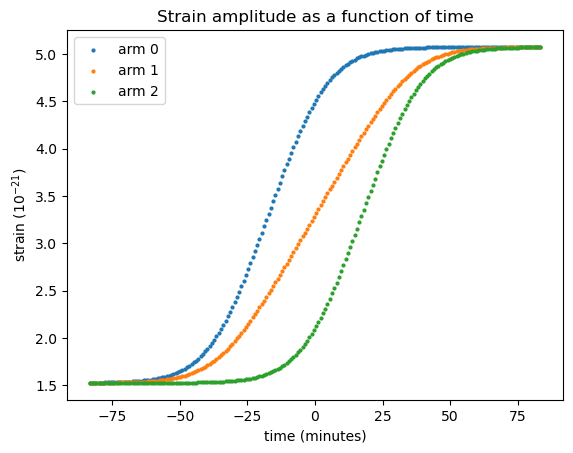

In [25]:
for i in averages:
    
    py.scatter(timemins, averages[i] * K * 10**21, s=4, label='arm ' +i[-1:]) #for each arm, plot for all angles
py.title('Strain amplitude as a function of time')
py.xlabel('time (minutes)')
py.ylabel('strain ($10^{-21}$)') #labelling output graph
py.legend()
py.show()


Finding the strain difference per time step simply requires subtracting the 'current' strain value from the 'previous' strain value. The issue with this method, however, is that with increasing samples per unit time (minutes in this case), the difference approaches 0. Hence, this result is normalized by dividing it by a 'delta time' term, scaling it by the sample rate. This effectively gives a numerical derivative.

$$
\frac{dh}{dt} \approx \frac{\Delta h}{\Delta t} = \frac{h_i - h_{i-1}}{\Delta t}
$$
here, $\Delta t$ is assumed to be a constant - and it is when using linspace.

<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
C:\Users\User\AppData\Local\Temp\ipykernel_18740\3842387187.py:7: SyntaxWarning: invalid escape sequence '\D'
  py.title('Strain change ($\Delta strain$) as a function of time')
C:\Users\User\AppData\Local\Temp\ipykernel_18740\3842387187.py:9: SyntaxWarning: invalid escape sequence '\D'
  py.ylabel('$\Delta Strain$ per second ($10^{-24}$)') #labelling output graph


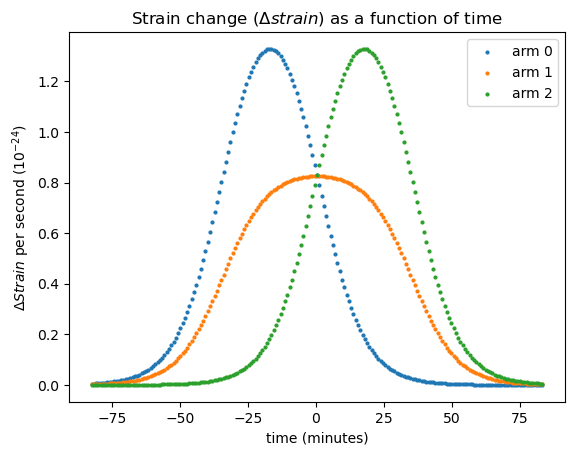

In [26]:
deltatime = time[1] - time[0] #difference between time samples (seconds)

for i in averages:
    
    py.scatter(timemins[1:], (averagesec[i][1:] - averagesec[i][:-1]) * K * 10**24 / deltatime, s=4, label='arm ' +i[-1:]) #for each arm, plot for all angles
    
py.title('Strain change ($\Delta strain$) as a function of time')
py.xlabel('time (minutes)')
py.ylabel('$\Delta Strain$ per second ($10^{-24}$)') #labelling output graph
py.legend()
py.show()

In [27]:
print(averages['avgdens0'] - averagesec['avgdens0']) #this shows that there is no difference between minutes and seconds when evaluating average density. 

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.44089210e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.44089210e-16  0.00000000e+00  0.00000000e+00
 -4.44089210e-16  0.00000000e+00 -4.44089210e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -8.88178420e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000